In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/mad_class22/final_quiz/')

In [13]:
!ls '/content/drive/My Drive/Colab Notebooks/mad_class22/final_quiz/'

final_quiz.ipynb  svm-test.txt	svm-train.txt


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import scipy.spatial

In [15]:
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)


In [16]:
def RBF_kernel(W,X,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        W, X - two matrices of size n1xd and n2xd respectively
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||W_{i,:}-X_{j,:}||^2/(2 sigma^2)) in position i,j
    """
    k = np.exp(- scipy.spatial.distance.cdist(W, X, "euclidean") ** 2 / (2 * sigma ** 2)) 
    return k 
    
  

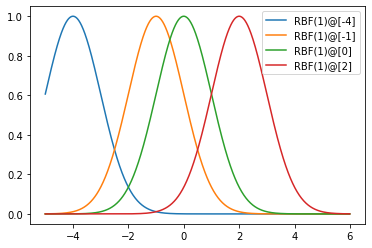

In [17]:
plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)


offset =1; degree=3; 


sigma = 1
y = RBF_kernel(prototypes, xpts, sigma) 
for i in range(len(prototypes)):
    label = "RBF("+str(sigma)+")@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 
 

In [18]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(W,X) - a function return the cross-kernel matrix between rows of W and rows of X for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        cross_kernel_matrix = self.kernel(X, self.prototype_points)
        return np.dot(cross_kernel_matrix,self.weights)

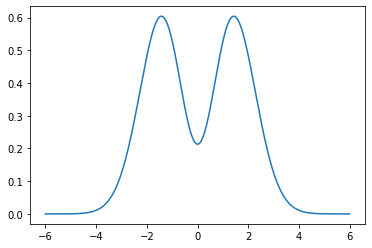

In [19]:
protos = np.array((-1,0,1)).reshape(-1,1)
weights = np.array((1,-1,1)).reshape(-1,1)
k = functools.partial(RBF_kernel, sigma=1)
f = Kernel_Machine(k, protos, weights)  

plot_step = .01
xpts = np.arange(-6.0 , 6, plot_step).reshape(-1,1)
plt.plot(xpts, f.predict(xpts))
plt.show() 

In [20]:
# load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.
data_train,data_test = np.loadtxt("./drive/My Drive/Colab Notebooks/mad_class22/final_quiz/svm-train.txt"),np.loadtxt("./drive/My Drive/Colab Notebooks/mad_class22/final_quiz/svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

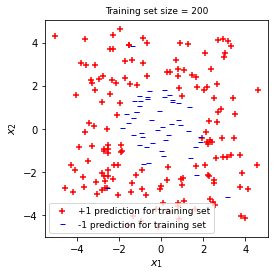

In [21]:
#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 prediction for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [22]:
""" train_soft_svm takes the numpy arrays containing 
 the measurements of x in R^{2 x d} and y in R^d, 
 the kernel, the maximum number of SGD steps T and 
 the regularization parameter Lambda. It returns 
 the corresponding Kernel_Machine  
"""
 
def train_soft_svm(X, y, kernel, T, Lambda):
    
    """ sgd_for_soft_svm implements SGD for soft-margin SVM.
     It takes the numpy arrays containing the features X, labels y in {-1,+1},
     the kernel K in R^{d x d} the maximum number of steps T and 
     the regularization parameter Lambda. It returns the coefficients alpha_bar
     of the solution w_bar represented as a linear combination  
     """
    def sgd_for_soft_svm (y, K, T, Lambda): 
      d = len(K) 
      alpha = np.ones(d) 
      for i in range(T): 
        for j in range(d): 
          m = K@alpha 
          if y[j] * m[j] < 1: 
            grad = - y[j] * K[j,: ] + Lambda * K @ alpha 
          else: 
            grad = Lambda * K @ alpha 
          alpha = alpha - 0.01 * grad 
      return alpha 
    K = kernel(X,X)
    alpha= sgd_for_soft_svm (y, K, T, Lambda)
    return Kernel_Machine(kernel, X, alpha)

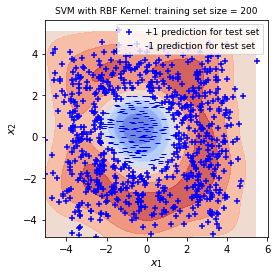

In [23]:
# Apply the SDG with RBF to the test set
T = 200       
Lambda = 0.0625 # in practice this parameter would be determined by regularization
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, T, Lambda)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()